# Tidy Text Case Studies

## Acknowledgements
We would like to acknowledge the work of Julia Silge and David Robinson, whose materials were used under the terms of the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States License. Their contributions to open data science education, particularly the [Text Mining with R](https://www.tidytextmining.com), provided valuable resources for this project.

This notebook was created by Meara Cox using their code and examples as a foundation, with additional explanations and adaptations to support the goals of this project.

## Install Packages

In [2]:
install.packages("lubridate")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("readr")


The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages


## Case study: Comparing Twitter Archives

Online text, especially from platforms like Twitter, receives a lot of attention in text analysis. Many sentiment lexicons used in this book were specifically designed for or validated on tweets, reflecting the unique language and style found there. Both authors of this book are active Twitter users, so this case study explores a comparison between the entire Twitter archives of [Julia](https://x.com/juliasilge) and [David](https://x.com/drob).


### Getting the Data and Distribution

Individuals can download their own Twitter archives by following [instructions provided on Twitter’s website](https://help.x.com/en/managing-your-account/how-to-download-your-x-archive). After downloading their archives, the next step is to load the data and use the **lubridate** package to convert the string-formatted timestamps into proper date-time objects. This conversion enables easier analysis of tweeting patterns over time. Initially, we can explore overall tweeting behavior by summarizing or visualizing the frequency and timing of tweets.



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




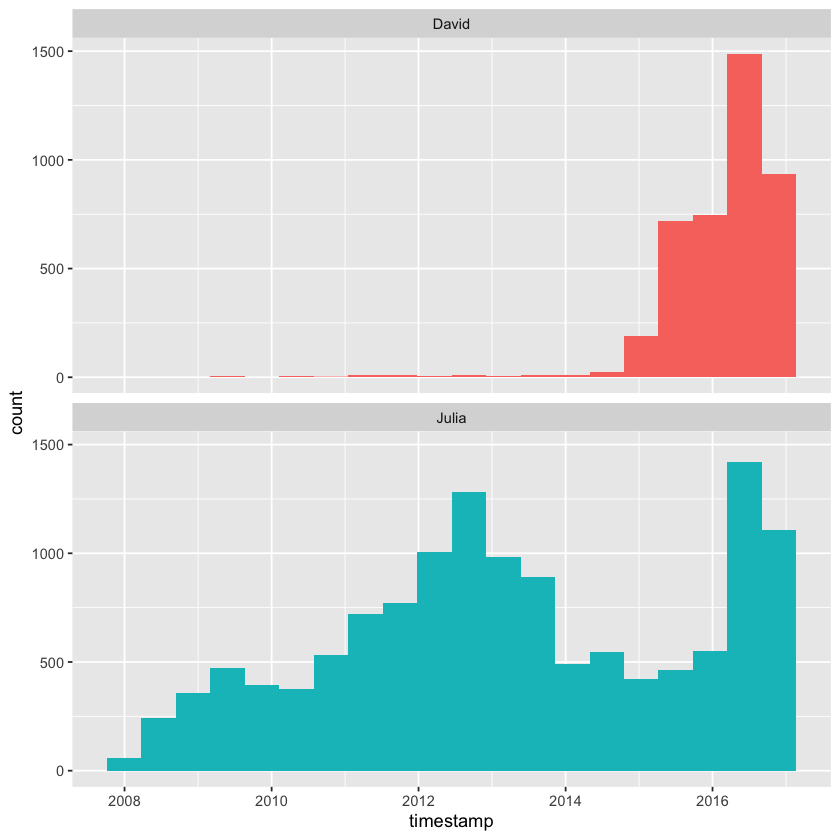

In [5]:
library(lubridate)
library(ggplot2)
library(dplyr)
library(readr)

tweets_julia <- read_csv("data/tweets_julia.csv", show_col_types = FALSE)
tweets_dave <- read_csv("data/tweets_dave.csv", show_col_types = FALSE)
tweets <- bind_rows(tweets_julia %>% 
                      mutate(person = "Julia"),
                    tweets_dave %>% 
                      mutate(person = "David")) %>%
  mutate(timestamp = ymd_hms(timestamp))

ggplot(tweets, aes(x = timestamp, fill = person)) +
  geom_histogram(position = "identity", bins = 20, show.legend = FALSE) +
  facet_wrap(~person, ncol = 1)

David and Julia currently tweet at roughly the same rate and joined Twitter about a year apart, but there was a period of about five years when David was inactive on the platform while Julia remained active. As a result, Julia has accumulated approximately four times as many tweets as David overall.

### Word Frequencies

We’ll use [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to create a tidy data frame containing all the words from our tweets and remove common English stop words. Since people use text on Twitter differently than in traditional narratives, we’ll use a specialized tokenizer and apply some additional text cleaning compared to what we did with Project Gutenberg text.

First, we’ll filter out retweets from the dataset to focus only on tweets we wrote ourselves. Then, the [`mutate()`](https://dplyr.tidyverse.org/reference/mutate.html) step removes links and unwanted characters like ampersands and other symbols.

In the [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) call, we use a regular expression pattern instead of extracting simple unigrams. This regex is particularly helpful for handling Twitter text or content from online platforms—it keeps hashtags and @ mentions intact.

Because hashtags and usernames remain in the dataset, using a basic [`anti_join()`](https://dplyr.tidyverse.org/reference/filter-joins.html) to remove stop words isn’t sufficient. Instead, the [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) line demonstrates how to use [`str_detect()`](https://stringr.tidyverse.org/reference/str_detect.html) from the **stringr** package to exclude stop words more effectively.


In [6]:
library(tidytext)
library(stringr)

replace_reg <- "https://t.co/[A-Za-z\\d]+|http://[A-Za-z\\d]+|&amp;|&lt;|&gt;|RT|https"
unnest_reg <- "([^A-Za-z_\\d#@']|'(?![A-Za-z_\\d#@]))"

tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         !word %in% str_remove_all(stop_words$word, "'"),
         str_detect(word, "[a-z]"))

We can now compute word frequencies for each individual. To do this, we first group the data by person and word, counting the number of times each word appears per person. Next, we perform a [`left\_join()`](https://dplyr.tidyverse.org/reference/mutate-joins.html) to bring in the total word counts for each person — Julia’s total is larger since she has more tweets overall. Finally, we calculate the frequency of each word for each person by dividing the word count by the total words they used.

In [10]:
frequency <- tidy_tweets %>% 
  count(person, word, sort = TRUE) %>% 
  left_join(tidy_tweets %>% 
              count(person, name = "total")) %>%
  mutate(freq = n/total)

print(frequency)

Joining with `by = join_by(person)`


# A tibble: 20,722 x 5
   person word               n total    freq
   <chr>  <chr>          <int> <int>   <dbl>
 1 Julia  time             584 74541 0.00783
 2 Julia  @selkie1970      570 74541 0.00765
 3 Julia  @skedman         531 74541 0.00712
 4 Julia  day              467 74541 0.00627
 5 Julia  baby             408 74541 0.00547
 6 David  @hadleywickham   315 20150 0.0156 
 7 Julia  love             304 74541 0.00408
 8 Julia  @haleynburke     299 74541 0.00401
 9 Julia  house            289 74541 0.00388
10 Julia  morning          278 74541 0.00373
# i 20,712 more rows


This gives us a clean and tidy data frame, but to visualize those frequencies with one person’s frequency on the x-axis and the other’s on the y-axis, we need to reshape the data. We can use tidyr’s [`pivot\_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html) function to transform the data frame so that each person’s word frequencies become separate columns, ready for plotting.

In [11]:
library(tidyr)

frequency <- frequency %>% 
  select(person, word, freq) %>% 
  pivot_wider(names_from = person, values_from = freq) %>%
  arrange(Julia, David)

print(frequency)

# A tibble: 17,629 x 3
   word                 Julia     David
   <chr>                <dbl>     <dbl>
 1 's               0.0000134 0.0000496
 2 1x               0.0000134 0.0000496
 3 5k               0.0000134 0.0000496
 4 @accidental__art 0.0000134 0.0000496
 5 @alice_data      0.0000134 0.0000496
 6 @alistaire       0.0000134 0.0000496
 7 @corynissen      0.0000134 0.0000496
 8 @jennybryan's    0.0000134 0.0000496
 9 @jsvine          0.0000134 0.0000496
10 @lizasperling    0.0000134 0.0000496
# i 17,619 more rows


This reshaped data is now ready for visualization. We can use [`geom_jitter()`](https://ggplot2.tidyverse.org/reference/geom_jitter.html) to help spread out the points, reducing the visual clumping that happens with low-frequency words. Additionally, setting `check_overlap = TRUE` on the text labels will prevent them from overlapping excessively, so only a subset of labels will appear clearly on the plot.

Warning message:
"Removed 14536 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 14536 rows containing missing values or values outside the scale range
(`geom_text()`)."


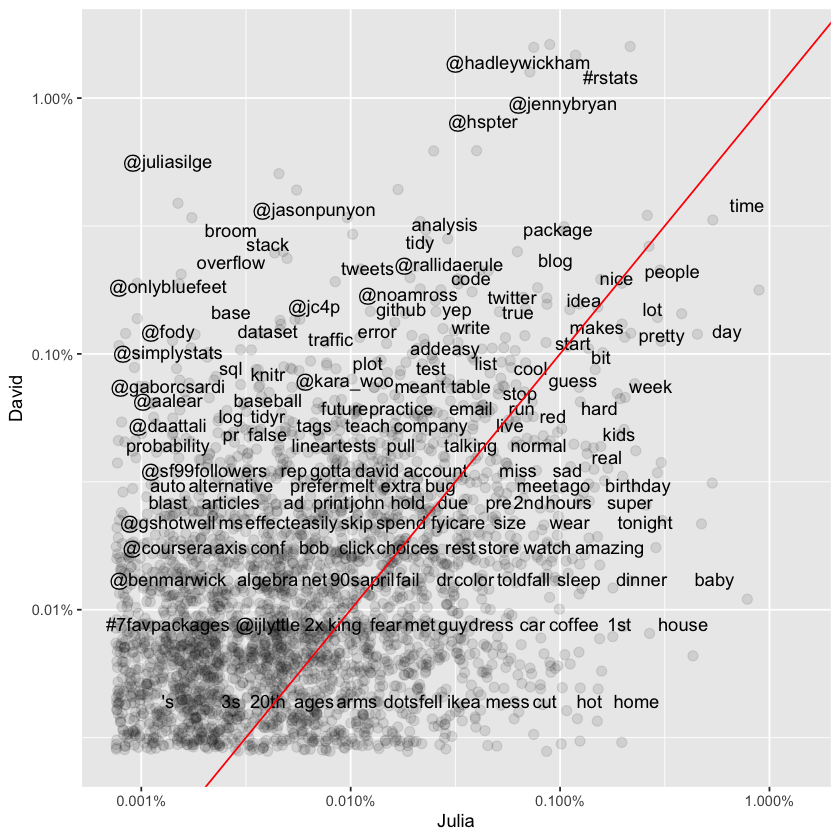

In [12]:
suppressPackageStartupMessages(library(scales))

ggplot(frequency, aes(Julia, David)) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.25, height = 0.25) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  geom_abline(color = "red")

Words that fall close to the diagonal line on the plot are used at roughly equal rates by both David and Julia. In contrast, words that sit farther from the line are more heavily favored by one person over the other. The plot only shows words, hashtags, and usernames that both individuals have used at least once in their tweets.

It’s clear from this visualization—and will continue to be throughout the chapter—that David and Julia have approached Twitter in very different ways over the years. David's tweets have been almost entirely professional since he became active, whereas Julia's early Twitter use was personal, and even now, her account retains more personal content than David's. This difference in usage patterns is reflected immediately in how they use language on the platform.

### Comparing Word Usage

We’ve already visualized a comparison of raw word frequencies across the entire Twitter histories of David and Julia. Now, let’s dig deeper by identifying which words are more or less likely to originate from each person’s account using the log odds ratio. To keep the comparison meaningful, we’ll limit the analysis to tweets from 2016—a year when David was consistently active on Twitter and Julia was transitioning into her data science career.

In [13]:
tidy_tweets <- tidy_tweets %>%
  filter(timestamp >= as.Date("2016-01-01"),
         timestamp < as.Date("2017-01-01"))

Next, we’ll use [`str_detect()`](https://stringr.tidyverse.org/reference/str_detect.html) to filter out Twitter usernames from our word column. Otherwise, the analysis would be dominated by names of people David or Julia know, which doesn’t tell us much about broader word usage differences.

Once usernames are removed, we count how many times each person uses each word and keep only words that appear more than 10 times to avoid results driven by very rare terms. After reshaping the data with [`pivot_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html), we calculate the **log odds ratio** for each word as:

$$
\text{log odds ratio} = \ln \left( \frac{(n + 1) / (total + 1) \text{ for David}}{(n + 1) / (total + 1) \text{ for Julia}} \right)
$$

Here:

* $n$ is the count of the word for each person,
* $total$ is the total word count for each person,
* Adding 1 to both numerator and denominator prevents division by zero for rare words.

This gives a clearer picture of which words are disproportionately associated with one person versus the other.


In [14]:
word_ratios <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  count(word, person) %>%
  group_by(word) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  pivot_wider(names_from = person, values_from = n, values_fill = 0) %>%
  mutate_if(is.numeric, list(~(. + 1) / (sum(.) + 1))) %>%
  mutate(logratio = log(David / Julia)) %>%
  arrange(desc(logratio))

Here are some words that have been about equally likely to come from David or Julia’s account during 2016.

In [15]:
word_ratios %>% 
  arrange(abs(logratio)) %>%
  print()

# A tibble: 377 x 4
   word         David   Julia logratio
   <chr>        <dbl>   <dbl>    <dbl>
 1 email      0.00229 0.00228  0.00463
 2 file       0.00229 0.00228  0.00463
 3 map        0.00252 0.00254 -0.00543
 4 names      0.00413 0.00406  0.0170 
 5 account    0.00183 0.00177  0.0328 
 6 api        0.00183 0.00177  0.0328 
 7 function   0.00367 0.00355  0.0328 
 8 population 0.00183 0.00177  0.0328 
 9 sad        0.00183 0.00177  0.0328 
10 words      0.00367 0.00355  0.0328 
# i 367 more rows


We are about equally likely to tweet about maps, email, files, and APIs.

To find the words most strongly associated with each account, we select the top 15 words with the highest positive log odds ratio (most likely from David’s account) and the top 15 words with the lowest (most negative) log odds ratio (most likely from Julia’s account).

Plotting these words will clearly show which terms are most distinctive for each person’s tweets, highlighting the differences in their language use during 2016.

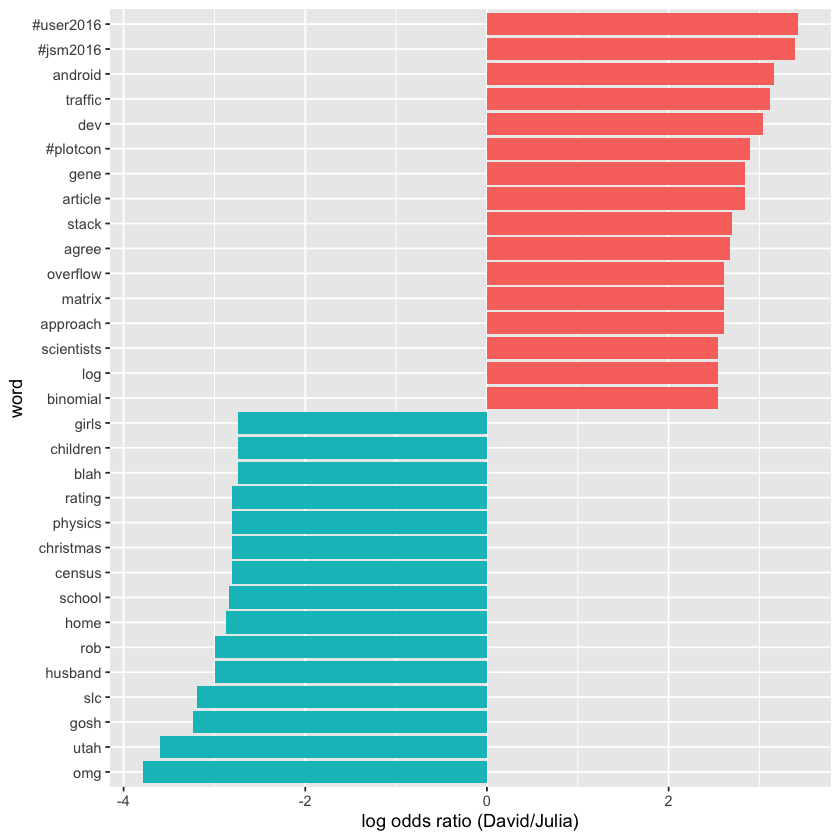

In [16]:
word_ratios %>%
  group_by(logratio < 0) %>%
  slice_max(abs(logratio), n = 15) %>% 
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio (David/Julia)") +
  scale_fill_discrete(name = "", labels = c("David", "Julia"))

David’s tweets tend to focus on professional topics like conferences and programming, reflecting his career interests, while Julia’s tweets highlight personal themes like family and regional topics such as Utah and Census data.

### Changes in Word Use

The previous section focused on overall word usage, but now we want to explore a different question: which words have changed in frequency the most over time in the Twitter feeds? In other words, which words have they tweeted about more or less as time has gone on?

To analyze this, we first create a new time variable in the data frame that groups each tweet into a specific time unit. Using lubridate’s [`floor_date()`](https://lubridate.tidyverse.org/reference/round_date.html) function, we round timestamps down to the start of each month, which works well for this year of tweets.

Once these time bins are set, we count how often each person used each word within each month. Then, we add columns showing the total words tweeted by each person per month and the total uses of each word by each person overall. Finally, we can [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) the data to keep only words that appear at least 30 times, ensuring we focus on words with sufficient usage for meaningful analysis.


In [17]:
words_by_time <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  mutate(time_floor = floor_date(timestamp, unit = "1 month")) %>%
  count(time_floor, person, word) %>%
  group_by(person, time_floor) %>%
  mutate(time_total = sum(n)) %>%
  group_by(person, word) %>%
  mutate(word_total = sum(n)) %>%
  ungroup() %>%
  rename(count = n) %>%
  filter(word_total > 30)

print(words_by_time)

# A tibble: 327 x 6
   time_floor          person word    count time_total word_total
   <dttm>              <chr>  <chr>   <int>      <int>      <int>
 1 2016-01-01 00:00:00 David  #rstats     2        306        208
 2 2016-01-01 00:00:00 David  broom       2        306         39
 3 2016-01-01 00:00:00 David  data        2        306        165
 4 2016-01-01 00:00:00 David  ggplot2     1        306         39
 5 2016-01-01 00:00:00 David  tidy        1        306         46
 6 2016-01-01 00:00:00 David  time        2        306         58
 7 2016-01-01 00:00:00 David  tweets      1        306         46
 8 2016-01-01 00:00:00 Julia  #rstats    10        401        116
 9 2016-01-01 00:00:00 Julia  blog        2        401         33
10 2016-01-01 00:00:00 Julia  data        5        401        111
# i 317 more rows


Each row in this data frame represents a single person’s use of a specific word within a particular time bin. The `count` column shows how many times that person used the word in that time period, `time_total` gives the total number of words the person tweeted during that time bin, and `word_total` indicates the total number of times that person used that word throughout the entire year. This dataset is ready to be used for modeling purposes.

Next, we can apply [`nest()`](https://tidyr.tidyverse.org/reference/nest.html) from tidyr to create a data frame where each word corresponds to a list-column containing smaller data frames—essentially mini datasets—for each word. Let’s go ahead and do that, then examine the structure of the resulting nested data frame.

In [18]:
nested_data <- words_by_time %>%
  nest(data = c(-word, -person)) 

print(nested_data)

# A tibble: 32 x 3
   person word    data             
   <chr>  <chr>   <list>           
 1 David  #rstats <tibble [12 x 4]>
 2 David  broom   <tibble [10 x 4]>
 3 David  data    <tibble [12 x 4]>
 4 David  ggplot2 <tibble [10 x 4]>
 5 David  tidy    <tibble [11 x 4]>
 6 David  time    <tibble [12 x 4]>
 7 David  tweets  <tibble [8 x 4]> 
 8 Julia  #rstats <tibble [12 x 4]>
 9 Julia  blog    <tibble [10 x 4]>
10 Julia  data    <tibble [12 x 4]>
# i 22 more rows


This data frame contains one row for each unique person-word pair, and the `data` column is a list-column holding smaller data frames for each of those pairs. We’ll use [`map()`](https://purrr.tidyverse.org/reference/map.html) from the purrr package [(Henry and Wickham 2018)](https://www.tidytextmining.com/references#ref-R-purrr) to run our modeling function on each of these nested data frames.

Since the data involves counts, we’ll fit a generalized linear model using [`glm()`](https://rdrr.io/r/stats/glm.html) with `family = "binomial"`. Essentially, this model answers a question like: “Was this particular word mentioned during this time bin (yes or no)? How does the likelihood of mentioning this word change over time?”

In [19]:
suppressPackageStartupMessages(library(purrr))

nested_models <- nested_data %>%
  mutate(models = map(data, ~ glm(cbind(count, time_total) ~ time_floor, ., 
                                  family = "binomial")))

print(nested_models)

# A tibble: 32 x 4
   person word    data              models
   <chr>  <chr>   <list>            <list>
 1 David  #rstats <tibble [12 x 4]> <glm> 
 2 David  broom   <tibble [10 x 4]> <glm> 
 3 David  data    <tibble [12 x 4]> <glm> 
 4 David  ggplot2 <tibble [10 x 4]> <glm> 
 5 David  tidy    <tibble [11 x 4]> <glm> 
 6 David  time    <tibble [12 x 4]> <glm> 
 7 David  tweets  <tibble [8 x 4]>  <glm> 
 8 Julia  #rstats <tibble [12 x 4]> <glm> 
 9 Julia  blog    <tibble [10 x 4]> <glm> 
10 Julia  data    <tibble [12 x 4]> <glm> 
# i 22 more rows


Now we see a new column holding the modeling results—this is another list-column, each entry containing a `glm` model object. The next step is to use [`map()`](https://purrr.tidyverse.org/reference/map.html) together with [`tidy()`](https://generics.r-lib.org/reference/tidy.html) from the broom package to extract the slope coefficients from each model.

Since we’re testing many slopes simultaneously and some won’t be statistically significant, we’ll adjust the p-values to account for multiple comparisons, helping to control for false positives.

In [20]:
library(broom)

slopes <- nested_models %>%
  mutate(models = map(models, tidy)) %>%
  unnest(cols = c(models)) %>%
  filter(term == "time_floor") %>%
  mutate(adjusted.p.value = p.adjust(p.value))

Next, we’ll identify the most notable slopes—that is, the words whose usage frequencies have changed over time with moderate statistical significance in our tweets. By filtering the results for adjusted p-values below a chosen threshold (e.g., 0.05), we can pinpoint these words and understand which topics or terms have become more or less common during the period analyzed.

In [21]:
top_slopes <- slopes %>% 
  filter(adjusted.p.value < 0.05)

print(top_slopes)

# A tibble: 6 x 9
  person word      data              term   estimate std.error statistic p.value
  <chr>  <chr>     <list>            <chr>     <dbl>     <dbl>     <dbl>   <dbl>
1 David  ggplot2   <tibble [10 x 4]> time_~ -8.27e-8   1.97e-8     -4.20 2.69e-5
2 Julia  #rstats   <tibble [12 x 4]> time_~ -4.49e-8   1.12e-8     -4.01 5.97e-5
3 Julia  post      <tibble [12 x 4]> time_~ -4.82e-8   1.45e-8     -3.31 9.27e-4
4 David  overflow  <tibble [10 x 4]> time_~  7.25e-8   2.23e-8      3.25 1.17e-3
5 David  stack     <tibble [10 x 4]> time_~  8.04e-8   2.19e-8      3.67 2.47e-4
6 David  #user2016 <tibble [3 x 4]>  time_~ -8.18e-7   1.55e-7     -5.27 1.34e-7
# i 1 more variable: adjusted.p.value <dbl>


To visualize these findings, we can create plots showing how the usage of these words has changed over the course of the year for both David and Julia. This will help illustrate trends in word frequency over time, highlighting the differences and similarities in their tweeting patterns throughout the year.

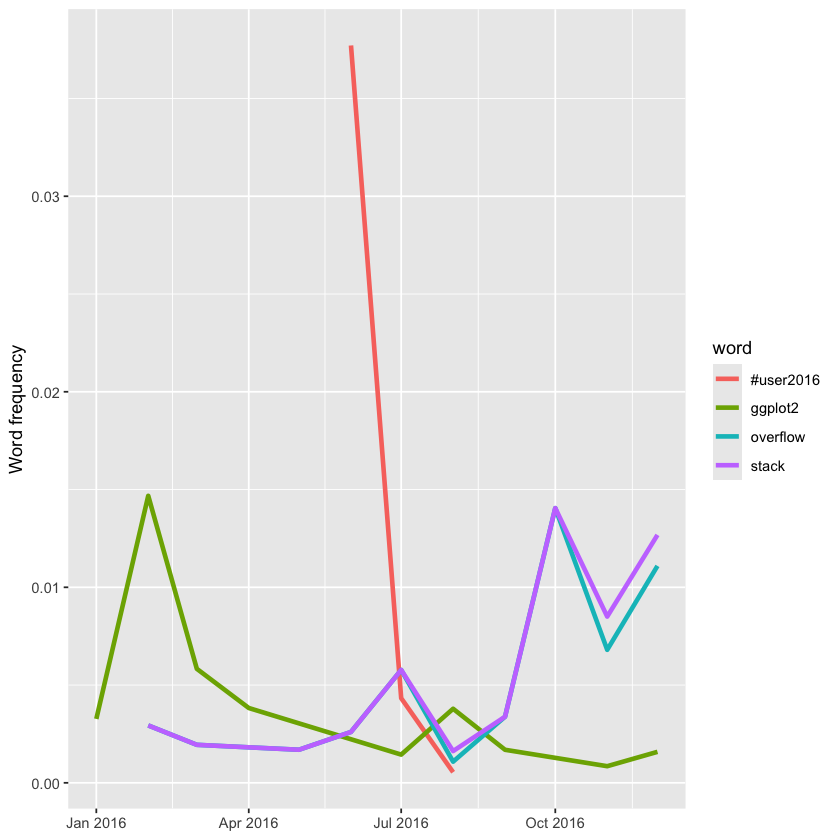

In [22]:
words_by_time %>%
  inner_join(top_slopes, by = c("word", "person")) %>%
  filter(person == "David") %>%
  ggplot(aes(time_floor, count/time_total, color = word)) +
  geom_line(linewidth = 1.3) +
  labs(x = NULL, y = "Word frequency")

This shows that David tweeted extensively about the UseR conference during the event, but his mentions dropped off quickly afterward. Additionally, his tweets about Stack Overflow increased toward the end of the year, while references to ggplot2 declined over time.

Now let’s plot words that have changed frequency in Julia’s tweets.


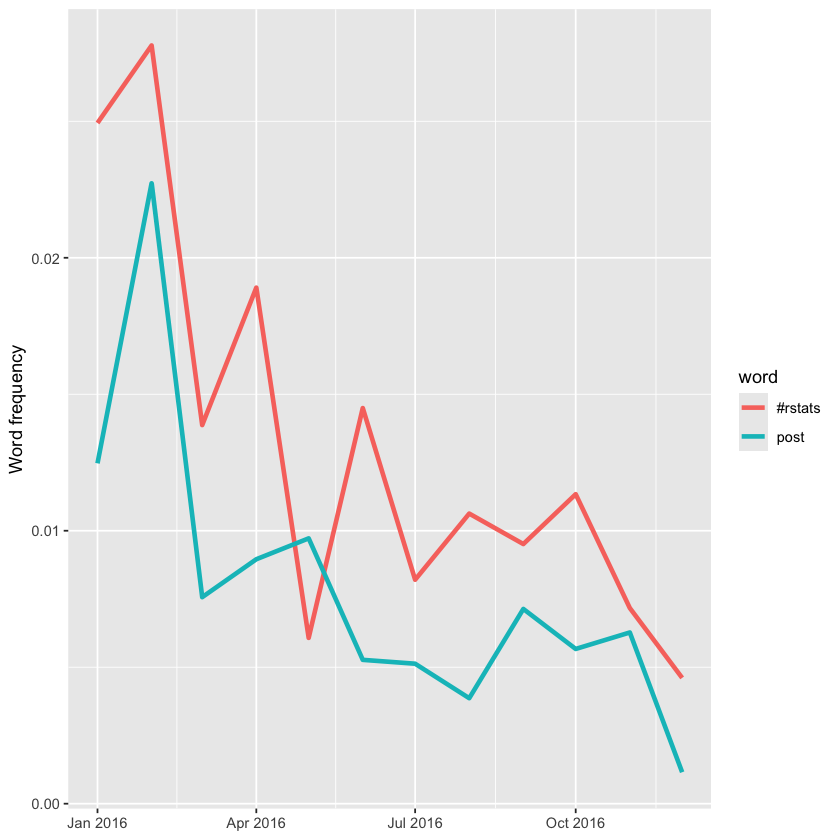

In [23]:
words_by_time %>%
  inner_join(top_slopes, by = c("word", "person")) %>%
  filter(person == "Julia") %>%
  ggplot(aes(time_floor, count/time_total, color = word)) +
  geom_line(linewidth = 1.3) +
  labs(x = NULL, y = "Word frequency")

All of Julia’s significant slopes are negative, indicating she hasn’t increased her use of any particular words over the year. Instead, she’s used a wider variety of words, with the ones shown in this plot appearing more frequently earlier in the year. For example, words related to sharing new blog posts—like the hashtag #rstats and the word “post”—have decreased in usage over time.

### Favorites and Retweets

Another key aspect of tweets is how often they get favorited or retweeted. To analyze which words are associated with higher engagement on Julia’s and David’s tweets, they created a separate dataset that includes favorites and retweets information. Since Twitter archives don’t include this data, they collected roughly 3,200 tweets for each of them directly from the Twitter API, covering about the last 18 months of activity—a period during which both of them increased their tweeting frequency and follower counts.


In [24]:
tweets_julia <- read_csv("data/juliasilge_tweets.csv", show_col_types = FALSE)
tweets_dave <- read_csv("data/drob_tweets.csv", show_col_types = FALSE)
tweets <- bind_rows(tweets_julia %>% 
                      mutate(person = "Julia"),
                    tweets_dave %>% 
                      mutate(person = "David")) %>%
  mutate(created_at = ymd_hms(created_at))

Now that we have this smaller, more recent dataset, we’ll again use [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to convert the tweets into a tidy format. We’ll filter out all retweets and replies to focus solely on the original tweets posted directly by David and Julia.

In [25]:
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^(RT|@)")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         !word %in% str_remove_all(stop_words$word, "'"))

print(tidy_tweets)

# A tibble: 11,074 x 7
        id created_at          source            retweets favorites person word 
     <dbl> <dttm>              <chr>                <dbl>     <dbl> <chr>  <chr>
 1 8.04e17 2016-12-01 16:44:03 Twitter Web Clie~        0         0 Julia  score
 2 8.04e17 2016-12-01 16:44:03 Twitter Web Clie~        0         0 Julia  50   
 3 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  snow~
 4 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  drin~
 5 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  tea  
 6 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  #rst~
 7 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  julie
 8 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  help~
 9 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  pyth~
10 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  pack~
# i 1

First, let’s examine how many times each person’s tweets were retweeted. We’ll calculate the total retweet count separately for David and Julia.

In [26]:
totals <- tidy_tweets %>% 
  group_by(person, id) %>% 
  summarise(rts = first(retweets)) %>% 
  group_by(person) %>% 
  summarise(total_rts = sum(rts))

print(totals)

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


# A tibble: 2 x 2
  person total_rts
  <chr>      <dbl>
1 David      13012
2 Julia       1749


Next, let’s calculate the median number of retweets for each word and person. To avoid counting duplicate tweet/word pairs, we’ll use [`group_by()`](https://dplyr.tidyverse.org/reference/group_by.html) and [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html) twice in succession. The first [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html) calculates how many times each word was retweeted, grouped by tweet and person. In the second [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html), we compute the median retweets for each word and person, while also counting how many times each word appeared overall for each person, saving that as `uses`. After that, we can join this to the data frame containing total retweet counts. Finally, we’ll use [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) to keep only the words that were mentioned at least five times.


In [27]:
word_by_rts <- tidy_tweets %>% 
  group_by(id, word, person) %>% 
  summarise(rts = first(retweets)) %>% 
  group_by(person, word) %>% 
  summarise(retweets = median(rts), uses = n()) %>%
  left_join(totals) %>%
  filter(retweets != 0) %>%
  ungroup()

word_by_rts %>% 
  filter(uses >= 5) %>%
  arrange(desc(retweets)) %>%
  print()

`summarise()` has grouped output by 'id', 'word'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
Joining with `by = join_by(person)`


# A tibble: 178 x 5
   person word          retweets  uses total_rts
   <chr>  <chr>            <dbl> <int>     <dbl>
 1 David  animation         85       5     13012
 2 David  download          52       5     13012
 3 David  start             51       7     13012
 4 Julia  tidytext          50       7      1749
 5 David  gganimate         45       8     13012
 6 David  introducing       45       6     13012
 7 David  understanding     37       6     13012
 8 David  0                 35       7     13012
 9 David  error             34.5     8     13012
10 David  bayesian          34       7     13012
# i 168 more rows


At the top of this sorted data frame, the most retweeted words for both Julia and David relate to packages they contribute to, such as [*gganimate*](https://gganimate.com) and [*tidytext*](https://cran.r-project.org/web/packages/tidytext/index.html). Next, we can create a plot showing the words with the highest median retweet counts for each account, highlighting which terms tend to garner more engagement on their tweets.

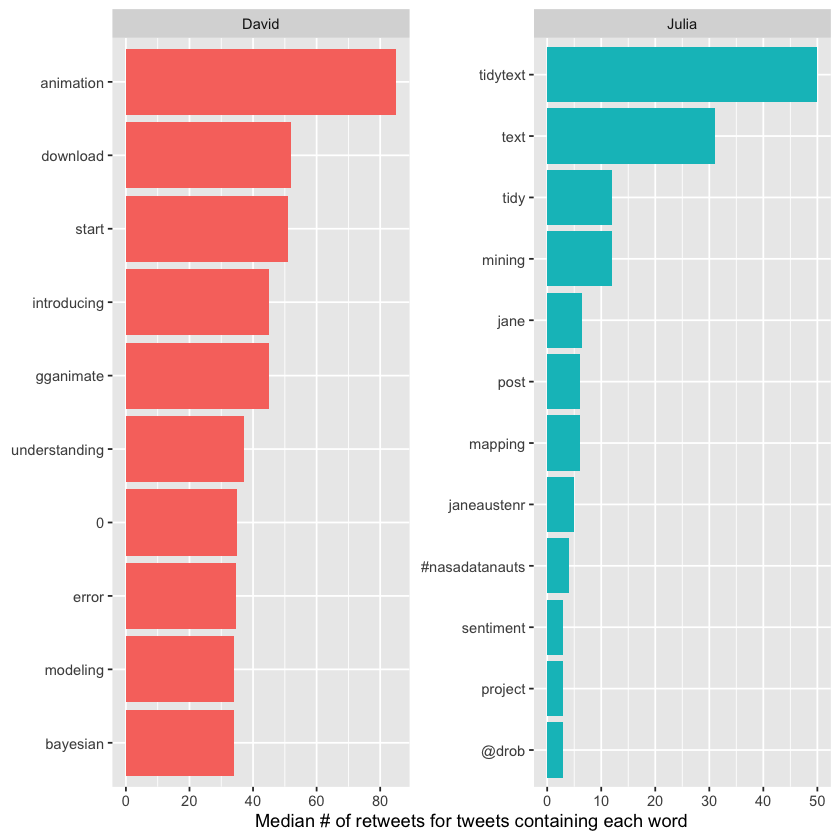

In [28]:
word_by_rts %>%
  filter(uses >= 5) %>%
  group_by(person) %>%
  slice_max(retweets, n = 10) %>% 
  arrange(retweets) %>%
  ungroup() %>%
  mutate(word = factor(word, unique(word))) %>%
  ungroup() %>%
  ggplot(aes(word, retweets, fill = person)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ person, scales = "free", ncol = 2) +
  coord_flip() +
  labs(x = NULL, 
       y = "Median # of retweets for tweets containing each word")

We notice many words related to R packages, including *tidytext*—the very package this book focuses on! The “0” values for David come from tweets mentioning package version numbers, like [“broom 0.4.0”](https://x.com/drob/status/671430703234576384) and similar.

Using a similar approach, we can analyze which words correspond to higher numbers of favorites. It will be interesting to see whether those words differ from the ones that lead to more retweets.

In [29]:
totals <- tidy_tweets %>% 
  group_by(person, id) %>% 
  summarise(favs = first(favorites)) %>% 
  group_by(person) %>% 
  summarise(total_favs = sum(favs))

word_by_favs <- tidy_tweets %>% 
  group_by(id, word, person) %>% 
  summarise(favs = first(favorites)) %>% 
  group_by(person, word) %>% 
  summarise(favorites = median(favs), uses = n()) %>%
  left_join(totals) %>%
  filter(favorites != 0) %>%
  ungroup()

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'id', 'word'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
Joining with `by = join_by(person)`


We have built the data frames we need. Now let’s make our visualization.

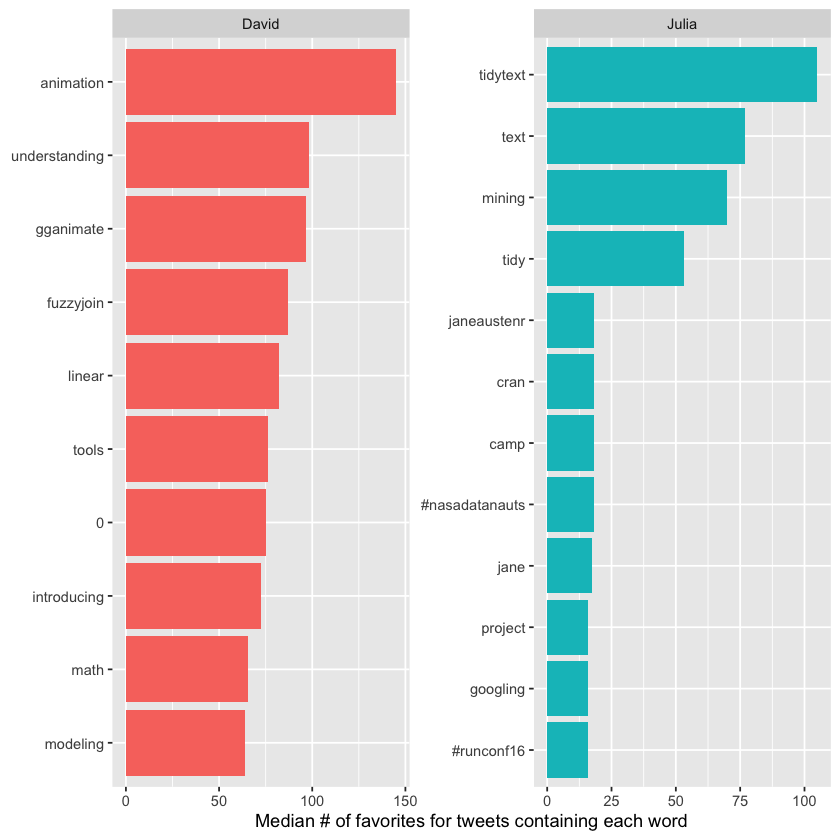

In [30]:
word_by_favs %>%
  filter(uses >= 5) %>%
  group_by(person) %>%
  slice_max(favorites, n = 10) %>% 
  arrange(favorites) %>%
  ungroup() %>%
  mutate(word = factor(word, unique(word))) %>%
  ungroup() %>%
  ggplot(aes(word, favorites, fill = person)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ person, scales = "free", ncol = 2) +
  coord_flip() +
  labs(x = NULL, 
       y = "Median # of favorites for tweets containing each word")

We notice some small differences between David and Julia, especially toward the lower end of the top 10 lists, but overall the words are mostly the same as those linked to retweets. Generally, the words that attract retweets also tend to attract favorites. A standout word for Julia in both charts is the hashtag for the NASA Datanauts program she’s been involved with.

## Case study: Mining NASA Metadata

[NASA](https://www.nasa.gov) maintains over 32,000 datasets that span topics ranging from Earth science to aerospace engineering to NASA's internal operations. To better understand the relationships between these datasets, we can analyze their metadata.

**What is metadata?**
Metadata refers to information that describes other data. In the context of NASA's datasets, this includes details like each dataset's title, description, responsible NASA organization, and human-assigned keywords. The metadata helps users understand the content and purpose of a dataset but does *not* include the dataset's actual measurements or results.

NASA strongly emphasizes open science, requiring [publicly accessible research outputs](https://www.nasa.gov/news-release/nasa-unveils-new-public-web-portal-for-research-results/). As part of this commitment, the metadata for all NASA datasets is available [online in JSON format](https://data.nasa.gov/data.json).

Below, we’ll treat NASA’s metadata as a text dataset and apply tidy text analysis methods to it. Using tools like word co-occurrence analysis, correlations, tf-idf, and topic modeling, we’ll explore questions such as:

* Can we identify relationships between datasets?
* Are there clusters of datasets with similar themes?
* How do different metadata fields (like titles, descriptions, and keywords) reveal patterns across NASA’s data catalog?

This approach demonstrates how text mining techniques can be applied to real-world, domain-specific metadata—whether in the space industry or any other field dealing with large collections of text. Let’s dive into the NASA dataset and begin exploring.

### How Data is Organized at NASA

We’ll start by getting the contents from the [JSON file](https://data.nasa.gov/data.json) and examining the field names contained in the metadata.

In [36]:
library(jsonlite)
metadata <- fromJSON("data/nasadata.json")
print(names(metadata$dataset))

 [1] "@type"              "title"              "description"       
 [4] "modified"           "accessLevel"        "identifier"        
 [7] "publisher"          "contactPoint"       "distribution"      
[10] "bureauCode"         "programCode"        "theme"             
[13] "keyword"            "spatial"            "temporal"          
[16] "issued"             "landingPage"        "accrualPeriodicity"
[19] "language"           "license"            "references"        
[22] "dataQuality"        "rights"             "describedBy"       
[25] "describedByType"   


We can see that this data allows us to pull information such as who published each dataset and the license under which it was released.

It’s likely that the title, description, and keywords associated with each dataset will be the most useful for identifying connections between them. Let’s take a closer look.

In [38]:
class(metadata$dataset$title)

class(metadata$dataset$description)

class(metadata$dataset$keyword)

[1] "character"

[1] "character"

[1] "list"

The title and description fields are saved as character vectors, while the keywords are stored as a list of character vectors.

#### Wrangling and Tidying the Data

We’ll create separate tidy data frames for the title, description, and keywords, making sure to keep the dataset IDs with each so we can link them together later if needed.

In [41]:
library(dplyr)

nasa_title <- tibble(id = metadata$dataset$`identifier`, 
                     title = metadata$dataset$title)
print(nasa_title)

# A tibble: 26,355 x 2
   id                               title                                       
   <chr>                            <chr>                                       
 1 10.26030/y7yh-6a61               Apollo 17 Challenge System - Seed Germinati~
 2 10.5067/SeaBASS/N01/DATA001      Zonal transect from Hawaii across the weste~
 3 10.7265/N52R3PNT                 Yup'ik Environmental Knowledge Project, Ver~
 4 10.7265/27c5-gz36                Yup'ik Environmental Knowledge Project (Com~
 5 10.5067/SeaBASS/ARCTICCC/DATA001 Yukon Arctic Carbon Cycle Project           
 6 10.5067/PRESW-YOJ10              Yongala Pre-SWOT Level-4 Hourly MITgcm LLC4~
 7 10.3334/ORNLDAAC/1596            WRF-STILT Particle Trajectories for Boston,~
 8 10.3334/ORNLDAAC/1572            WRF-STILT Gridded Footprints for Boston, MA~
 9 10.57909/Maxar/WV04_Pan_L1B.001  WorldView-4 Level 1B Panchromatic Satellite~
10 10.57909/Maxar/WV03_MSI_L2A.001  WorldView-3 Level 2A Multispectral 8-Band S~
# i 2

## Case Study: Analyzing Usenet Text

In our final chapter, we’ll apply the techniques from this book to complete an end-to-end analysis of 20,000 messages posted to 20 Usenet bulletin boards in 1993. These bulletin boards cover a variety of topics such as politics, religion, cars, sports, and cryptography, providing a diverse collection of user-generated text. This dataset is publicly available at [http://qwone.com/\~jason/20Newsgroups/](http://qwone.com/~jason/20Newsgroups/) (specifically the `20news-bydate.tar.gz` file) and is widely used for text analysis and machine learning exercises.


### Pre-processing

We’ll begin by reading all the messages from the `20news-bydate` folder, where the files are organized into sub-folders, with one file per message. We can load these files using a combination of [`read_lines()`](https://readr.tidyverse.org/reference/read_lines.html), [`map()`](https://purrr.tidyverse.org/reference/map.html), and [`unnest()`](https://tidyr.tidyverse.org/reference/unnest.html).

Keep in mind that this step may take several minutes to process all the documents.

In [ ]:
library(dplyr)
library(tidyr)
library(purrr)
library(readr)